# Machine Learning

## Key concepts

1. Overfitting
2. Evaluation metrics: accuracy, precision, recall
3. Two learning paradigms
4. Moons and circles
5. Handwriting recognition

*Side note for today:* no exercises in-class, but we will leave a few DIY exercises to do on your own. Instead, we will spend 1/2 time on lecture, 1/2 time thinking about project ideas.

## Overview

Previous goals involved **making inferences** from the data:

* summarizing patterns (identifying the empirical distribution);
* checking beliefs against observations (testing a hypothesis);
* specifying explanatory variables (fitting a linear regression).

Today's goal involves **learning models** from the data; i.e., computing a relationship in the data that will generalize to new settings.

*Discuss:*

* How do we learn?
* How can we measure how well a "learned" relationship will generalize?


## 1. Overfitting


One type of *model* to be learned is how some variable $x$ relates to some label $y$. Suppose you have sample data $(X_1, Y_1), \dots, (X_n, Y_n)$ and you suspect

$$ Y_i \approx f(X_i), \quad i=1, \dots, n, $$

and you want to make a guess for the function $f$ that will *generalize* (i.e., $f$ will be accurate on new data).

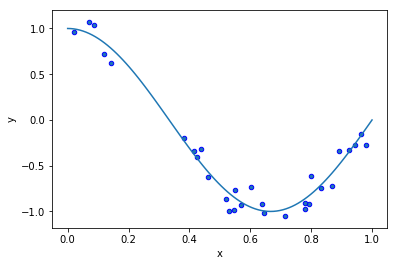

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

N_SAMPLES = 30

def true_foo(X):
    return np.cos(1.5 * np.pi * X)
  
np.random.seed(0)
X = np.random.rand(N_SAMPLES)
y = true_foo(X) + np.random.randn(N_SAMPLES) * 0.1
X_test = np.linspace(0, 1, 100)

plt.plot(X_test, true_foo(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

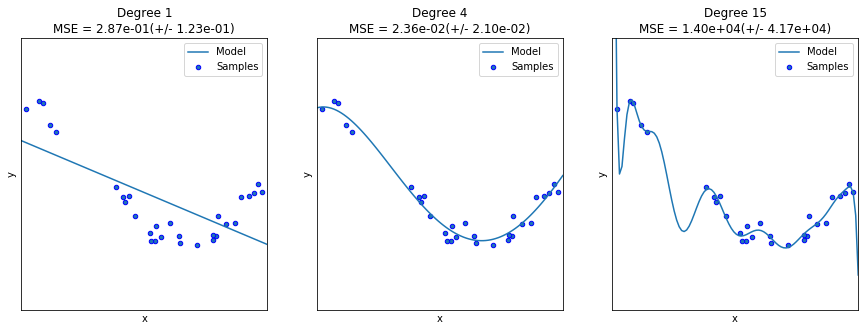

In [0]:
# Fit the samples with different polynomial degrees
degrees = [1, 4, 15]

plt.figure(figsize=(15, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(
        degree=degrees[i],
        include_bias=False,
    )
    linear_regression = LinearRegression()
    pipeline = Pipeline([
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression)
    ])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, 
        X[:, np.newaxis], 
        y,
        scoring="neg_mean_squared_error", 
        cv=10,
    )

    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
#     plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], 
        -scores.mean(), 
        scores.std(),
    ))
    
plt.show()

### A note on cross-validation

![k-folds](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

*Discuss:* What is the effect of changing $k$ in the $k$-fold cross-validation depicted above?Dis

## 2. Evaluation metrics

Previously, you learned about **sum of squared errors** as a loss,

$$ \text{squared error loss} = \frac{1}{N} \sum_{i=1}^N (\text{predicted}_i - \text{actual}_i)^2,$$

which describes: *how far are my predictions from the truth, on average?* When dealing with discrete data, sometimes you will prefer other evaluation metrics. Suppose your $\text{actual}$ labels can be either $+1$ or $-1$. Predictions can then be:

![confusion matrix](https://cdn-images-1.medium.com/max/1600/1*OhEnS-T54Cz0YSTl_c3Dwg.jpeg)

Some example evaluation metrics are: **accuracy**, which measures *how correct are my predictions?*,

$$\text{accuracy} := \frac{\#\{\text{true positive or true negative}\}}{\#\{\text{predicted}\}},$$


or **precision**, which measures *of my positive predictions, how many did I classify correctly?*,

$$\text{precision} := \frac{\#\{\text{true positive}\}}{\#\{\text{predicted positive}\}},$$

or **recall**, which measures *of all positive data points, how many did I classify correctly?*

$$\text{recall} := \frac{\#\{\text{true positive}\}}{\#\{\text{actual positive}\}}.$$

*Discuss:* When might precision matter more than recall, or vice versa?

*DIY later:* given vector of predicted and actual classes, compute the metrics above.


In [0]:
import numpy as np

example_actual = np.array([-1, -1, -1, 1, ])
example_predicted = np.array([-1, 1, 1, -1, -1])

def evaluate(actual: np.array, predicted: np.array, metric: str):
  if metric == 'squared':
    pass  # do this later!
  
  elif metric == 'accuracy':
    pass  # do this later!
    
  elif metric == 'precision':
    pass  # do this later!
    
  elif metric == 'recall':
    pass  # do this later!
    
  else:
    raise NotImplementedError("Not yet implemented!")

## 3. Two learning paradigms


* **Extrapolate:** discover some underlying structure in the data, and use this structure to create simple rules from which to extrapolate predictions for new settings.
* **Memorize:** record all data, and when faced with a new setting, find the old data most similar to the new data, and use that old data as a blueprint for prediction.



### Extrapolate: logistic regression

Consider the relationship of tumor size (our $X$ variable) and malignancy (a binary $Y$ label). *Linearity* is one example of underlying structure that we can use here.

In the continuous setting, you have seen *linear regression* -- as $X$ changes, the value of the label $Y$ is expected to change by $X^T\beta$.

$$ \mathbb{E}[Y | X] = X^T\beta.$$

In the discrete setting (e.g., the binary $+1$ vs. $-1$ above), the analog is *logistic regression* -- as $X$ changes, the _logarithm of the probability_ that the label $Y$ equals $+1$ increases by $X^T\beta$.
$$\log \mathbb{P}(Y = +1 \, |\, X) = X^T\beta.$$

![Tumor size vs. malignancy](http://www.holehouse.org/mlclass/06_Logistic_Regression_files/Image.png)

Ultimately, we want classifications, not log-probabilities -- to do so, pick some threshold, and above it classify as $+1$, below it classify as $-1$. The threshold can be shifted up and down in order to get the best evaluation metric of your choice (e.g., accuracy, recall, precision).

*Discuss:* You know about the assumptions baked into linear regression -- what about logistic regression?

### Memorize: k-nearest neighbors

Suppose we need to determine whether a datapoint is of type A or type B – e.g., we have demographic information for an individual and we want to guess whether they are a Republican or a Democrat. 

1.	Choose a positive integer $k$, say $k=3$.
2.	Choose a distance metric `dist` – e.g., Euclidean distance.
3.	For given datapoint $i$, assign $i$ the classification of the majority of its $k$ nearest neighbors, where "nearest" is with respect to `dist`.

*Discuss:* How would we use cross-validation with this algorithm? 

*Discuss:* What are some problems with low values of $k$? How about high values of $k$? 


## 4. Moons and circles

In [0]:
# adapted from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

names = ["logistic regression", "nearest neighbors", ]
classifiers = [LogisticRegression(solver='lbfgs'), KNeighborsClassifier(3),]

X, y = make_classification(
    n_features=2, 
    n_redundant=0, 
    n_informative=2,
    random_state=1, 
    n_clusters_per_class=1,
)

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    linearly_separable,
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
]

Plot how the algorithms operate: 

* training points are solid, testing points are translucent;
* bottom-right corner indicates test set accuracy;
* columns are {input data, logistic regression, k-nearest neighbors};
* rows are {linearly separable, moons, circles}.

*Discuss:* What structure seems "easy" or "hard" to learn? Why?

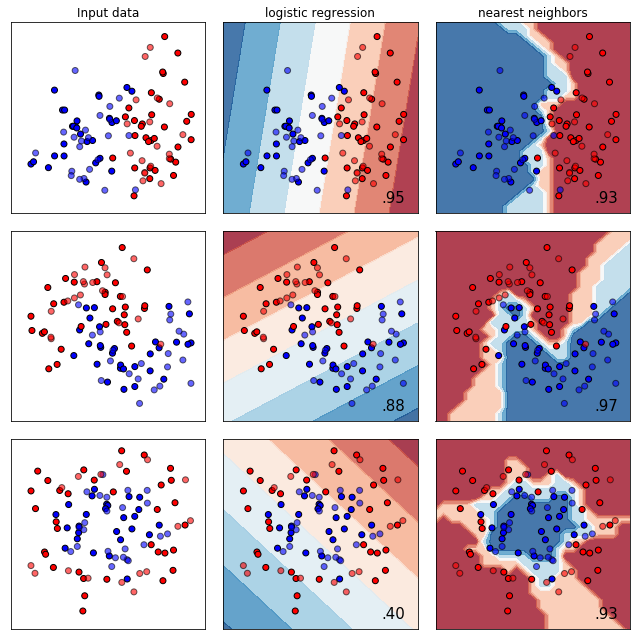

In [0]:
figure = plt.figure(figsize=(9, 9))
i = 1
h = 0.2  # for mesh
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

## 5. Handwriting recognition

What about real data? The first example we looked at was *one-dimensional*: fitting a curve. The second example was *two-dimensional*: finding some perimeter with which to separate two classes in a plane. 

Real data is different in two key ways:

1. The example data above were generated from some "true function" -- there is no true function in real data.
2. Real data tends to be high-dimensional, not just 1D or 2D. 

One example is images: each pixel is a dimension, so an 8 x 8 image has 64 dimensions.

In [0]:
# Part of the code is borrowed from 
# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics

# The digits dataset
digits = datasets.load_digits()

print (len(digits.images))
print (len(digits.target))

images_and_labels = list(zip(digits.images, digits.target))
print (images_and_labels[0])

1797
1797
(array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]]), 0)


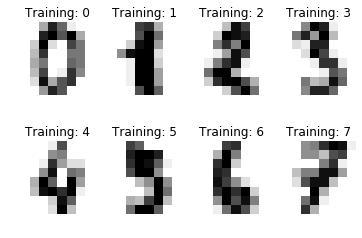

In [0]:
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size.
# For these images, we know which digit they represent: it is given in the 'target' of
# the dataset.

for index, (image, label) in enumerate(images_and_labels[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('Training: %i' % label)
    
plt.show()

In [0]:
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
print (data[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


I will demonstrate one very naive classifier: *always guess 2*.

*DIY later:* How can you do better?

In [0]:
class Naive:
  def __init__(self, constant):
    self.constant = constant
   
  def fit(self, x, y):
    return
  
  def predict(self, x):
    return self.constant * np.ones(len(x))

  
classifier = Naive(constant=2)

In [0]:
# We learn the digits on the first half of the digits
classifier.fit(data[:n_samples // 2], digits.target[:n_samples // 2])

# Now predict the value of the digit on the second half:
expected = digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])


print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))


Classification report for classifier <__main__.Naive object at 0x7f8becafc978>:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        88
           1       0.00      0.00      0.00        91
           2       0.10      1.00      0.17        86
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00        92
           5       0.00      0.00      0.00        91
           6       0.00      0.00      0.00        91
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00        88
           9       0.00      0.00      0.00        92

   micro avg       0.10      0.10      0.10       899
   macro avg       0.01      0.10      0.02       899
weighted avg       0.01      0.10      0.02       899


Confusion matrix:
[[ 0  0 88  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0 92

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


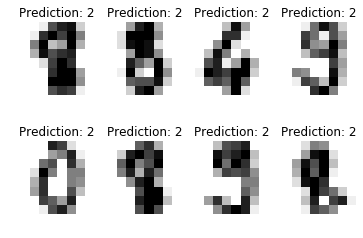

In [0]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('Prediction: %i' % prediction)

plt.show()

### Supervised vs. unsupervised 

Everything we’ve done today is *supervised learning*. That is, we had an “answer key” with which we trained each algorithm. What about algorithms that are made to detect similarities and patterns on their own? This is called *unsupervised learning*. 

One popular unsupervised learning algorithm is $k$-means clustering. 

*DIY later:* Look into [$k$-means clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), and note that a $Y$ variable is not a required input. How can you use this algorithm for handwriting recognition? How does the approach fare compared to supervised learning?
